In [1]:
import numpy as np
from pint import UnitRegistry
import math
ureg = UnitRegistry()
np.set_printoptions(precision=4)
import sys
sys.path.append('/Users/Lampe/PyScripts/surgeAnalysis')
# import SurgeFunc as sf

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# General Class for Calculation of Steady-State Pressure Loss in Conduit

In [4]:
class SS_DeltaH():
    
    def __init__(self, flowRate, dynVisc, spGrav, ID, roughness, length, degTheta = 90., units = 0):
        """
            General class for calculating the Darcy-Weisbach Friction Factor.
            
            All calculations will be performed in consisten SI units.  
            Therefore, if units are input in US terms (units=0), they will be converted to SI for calculation.
            
            Units for Input (must maintain a constant system of units):
            
                      |   DESCRIPTION      | US     | SI   |
            units     |system of units     | =0     | !=0  |
            ------------------------------------------------
            flowRate  |volumetric flow rate|gal/min |m3/hr |
            dynVisc   |dynamic viscosity   |cP      |Pa-s  |
            spGrav    |specific gravity    |none    |none  |
            ID        |internal diameter   |inch    |mm    |
            roughness |pipe roughness      |inch    |mm    |
            length    |length of flow      |feet    |m     |
            degTheta  |CCW Angle From Horiz|degree  |degree|
                      |in + flow direction |
        """
        self.Q = flowRate
        self.mu = dynVisc
        self.sg = spGrav
        self.ID = ID
        self.roughness = roughness
        self.L = length
        self.units = units
        self.theta = np.pi / 180. * degTheta
        
        
    def ConvertIn(self):
        """
        Calculations will all be performed in SI units; therefore, this method converts from US to SI units
        """
        self.rho = self.sg * 1000 #kg/m3
        if self.units == 0:
            #convert from US to SI units
            self.L = self.L * 0.3048 #m
            self.Q = self.Q *3.7853/1000. / 60. # m3/sec
            self.ID = self.ID * 2.54 / 100. # m
            self.area = np.pi * self.ID **2 / 4.# m2
            self.v = self.Q / self.area # m/sec
            self.mu = self.mu * 10**-3 # Pa-s
            self.roughness = self.roughness * 2.54 / 100. # m
            textOut = "Input Was US Units"
        else:
            #convert to consistent SI units
            self.Q = self.Q / 3600. # m3/sec
            self.ID = self.ID / 1000. # m
            self.area = np.pi * self.ID **2 / 4.# m2
            self.v = self.Q / self.area # m/sec
            self.roughness = self.roughness / 1000. #m
            textOut = "Input Was SI Units"
        return self
    
    def Re(self):
        """
        Calculates Reynolds Number
         - this method may be called to check the Reynolds Number
        """
        self.Re = self.rho * self.v * self.ID / self.mu
        return self
        
    def FricFact(self):
        """
        Function to obtain the Darcy-Weisbach friction factor:
            Laminar Flow (Re <= 2000) -> Poiseuille's relationship
            Turbulent Flow (Re > 2000) -> evaluate the colebrrok-white equation 

        Input:
        -------------------------------------------------
        Re (required): reynolds number (dimensionless)
        d  (required): hydraulic diameter (length)
        epsilon (required): conduit roughness (length)

        Output:
        -------------------------------------------------
        f: darcy-weisbach friction factor (dimensionless)
        """
        if self.Re <= 2000.:
            f = self.Re / 64.
        else:
            sqrt_f = 10.0 # initial guess
            loop_max = 20 # max. number of loops
            inc = 1 # increment count
            res = 10.0 # initial value

            while res > 10**-8 and inc < loop_max:
                LHS = -2.0 * np.log10(self.roughness / (3.7 * self.ID) + 2.51 / (self.Re * sqrt_f))
                res = (LHS - 1./sqrt_f)**2 #squared error
                sqrt_f = 1./LHS
                inc = inc + 1
            f = sqrt_f**2

            if inc == loop_max:
                outText = "Friction Factor Did NOT Converge! Printed Value Should = 1.0"
                print(outText)
                print(-2.0 * np.log10(self.roughness / (3.7 * self.ID) + 2.51 / (self.Re * f**0.5)) * f**0.5)
                
        self.f = f
        return self
    
    def HeadLoss(self):
        """
        Calculates the change in piezometric head for steady-state flow
        accounts for head loss resulting from:
            -friction
            -change in elevation
        """
        g = 9.806 #m/s2
        self.dh_m = -self.f * (self.Q)**2 * self.L / (2 * self.ID * self.area**2*g) - np.sin(self.theta)*self.L
        self.dp_Pa = self.rho * g * self.dh_m
        return self
    
    def ConvertOut(self):
        """
        Converts units for return to user
        US Units:
            - head loss: feet
            - pressure loss: psi
            - velocity: ft/sec
        SI Units:
            - head loss: meter
            - pressure loss: MPa
            - velocity: m/sec
        """
        if self.units == 0:
            self.dh = self.dh_m / 0.3048 # feet
            self.dp = self.dp_Pa * 1.4504 * 10**-4 # psi
            self.v = self.v /0.3048 # ft/sec
        else:
            self.dh = self.dh_m # m
            self.dp = self.dp_Pa / 10**6 # MPa
            self.v = self.v # m/sec
        return self
                       
    def Calc(self):
        """
        This method must be called to obtain any needed parameters
        """
        self.ConvertIn()
        self.Re()
        self.FricFact()
        self.HeadLoss()
        self.ConvertOut()
        return self

# Calculate Steady-State Pressure Distribution For Vertical Coduit

** Problem Data **
* Governing Equation: $\frac{1}{\rho}\frac{\partial p}{\partial x} + g sin(\theta) + \frac{f v |v|}{2D} = 0$
 * Conservation of Momentum (Steady-State)
* Domain: $0 \le x \le L$
  * L = 1000 meters (ground surface)
  * 0 $\implies$ End of Hanging String
  * $D = 0.2 \; m$  
* Coeficient Function
 * $\rho = 1200 \; kg/m^3$ (SG = 1.2)
* Boundary Conditions
 * $v=v_0 = 5 \; m/sec$ (flowrate = 0.157 $m^3/hr$)

### Calculations in SI units

In [17]:
q = 0.15707963267948968*3600# m3/hr
mu = 1.60 * 10**-3 # Pa-s, N-s/m2
sg = 1.2 #rho = 1200 # kg/m3
d = 219.1 # mm
rough = 0.9 # roughness (mm)
L = 1000. # conduit lenth (m)

f = SS_DeltaH(q, mu, sg, d, rough, L, units=1).Calc().f
Re = SS_DeltaH(q, mu, sg, d, rough, L, units=1).Calc().Re
dh = SS_DeltaH(q, mu, sg, d, rough, L, units=1).Calc().dh
dp = SS_DeltaH(q, mu, sg, d, rough, L, units=1).Calc().dp
v = SS_DeltaH(q, mu, sg, d, rough, L, units=1).Calc().v
print(f) # friction factor
print(Re)# Reynold's number
print(dh)# change in head (m)
print(dp)# change in presure (MPa)
print(v) # velocity (m/sec)

0.0288009074525
684618.895482
-1116.34089235
-13.1362065485
4.16624917378


Let pressure at end of tubing = 20 MPa

In [18]:
z = np.linspace(0., L, 101)
h = np.zeros(len(z)) # head (m)
p = np.zeros(len(z)) # pressure (Pa)
dp = np.zeros(len(z)) # pressure (Pa)

p0 = 20 # MPa
dp = SS_DeltaH(q, mu, sg, d, rough, z, units=1).Calc().dp
p = p0 + dp

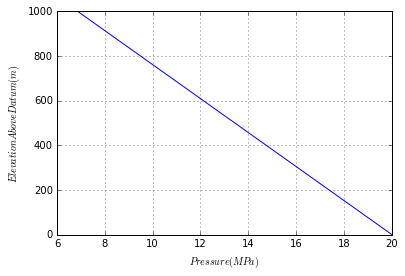

In [19]:
plt.plot(p,z)
plt.xlabel('$Pressure (MPa)$')
plt.ylabel('$Elevation Above Datum (m)$')
plt.grid()

### Cacluations in US units

In [20]:
q = 0.15707963267948968*3600# m3/hr
q = q * 7.48052 / (.3048**3  *60) # gpm

mu = 1.60 * 10**-3 # Pa-s, N-s/m2
mu = mu * 10 **3 # cP

sg = 1.2 #rho = 1200 # kg/m3

d = 219.1 # mm
d = d* 12./304.8 # inch

rough = 0.9 # roughness (mm)
rough = rough * 12./304.8 # inch

L = 1000. # conduit lenth (m)
L = L / .3048 # feet

f = SS_DeltaH(q, mu, sg, d, rough, L, units=0).Calc().f
Re = SS_DeltaH(q, mu, sg, d, rough, L, units=0).Calc().Re
dh = SS_DeltaH(q, mu, sg, d, rough, L, units=0).Calc().dh
dp = SS_DeltaH(q, mu, sg, d, rough, L, units=0).Calc().dp
v = SS_DeltaH(q, mu, sg, d, rough, L, units=0).Calc().v
print(f) # friction factor
print(Re)# Reynold's number
print(dh)# change in head (ft)
print(dp)# change in presure (psi)
print(v) # velocity (ft/sec)

0.0288009122139
684598.726084
-3662.51330939
-1905.26373129
13.6683938087


In [23]:
z = np.linspace(0., L, 101)
h = np.zeros(len(z)) # head (m)
p = np.zeros(len(z)) # pressure (Pa)
dp = np.zeros(len(z)) # pressure (Pa)

p0 = 20*14.7/.101325 # MPa
dp = SS_DeltaH(q, mu, sg, d, rough, z, units=0).Calc().dp
p = p0 + dp

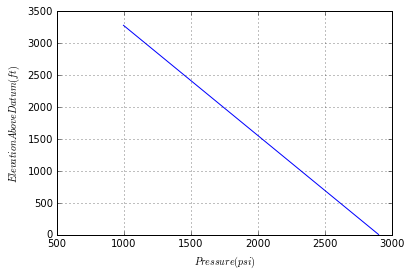

In [24]:
plt.plot(p,z)
plt.xlabel('$Pressure (psi)$')
plt.ylabel('$Elevation Above Datum (ft)$')
plt.grid()